# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

In [ ]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [ ]:
%pylab inline

### Загрузка данных

In [ ]:
raw_data = pd.read_csv('bike_sharing_demand.csv', header = 0, sep = ',')

In [ ]:
raw_data.head()

### Предобработка данных

#### Обучение и отложенный тест

In [ ]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [ ]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)
raw_data['year'] = raw_data.datetime.apply(lambda x : x.year)
raw_data['week_day'] = raw_data.datetime.apply(lambda x : x.weekday() + 1)

In [ ]:
raw_data.head()

In [ ]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [ ]:
print raw_data.shape, train_data.shape, hold_out_test_data.shape

In [ ]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [ ]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [ ]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [ ]:
train_data.columns

In [ ]:
print binary_data_columns
print binary_data_indices

In [ ]:
categorical_data_columns = ['season', 'weather', 'month', 'week_day'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

In [ ]:
print categorical_data_columns
print categorical_data_indices

In [ ]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'year']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

In [ ]:
print numeric_data_columns
print numeric_data_indices

### Pipeline

In [33]:
regressor = linear_model.SGDRegressor(random_state = 0, n_iter = 3, loss = 'squared_loss', penalty = 'l2')

In [47]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean=False))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [48]:
estimator.fit(train_data, train_labels)

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x114d277d0>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[('select...r=3, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))])

In [49]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

6204170740498450.0

### Подбор параметров

In [51]:
regressor.get_params().keys()

['warm_start',
 'loss',
 'eta0',
 'verbose',
 'shuffle',
 'fit_intercept',
 'l1_ratio',
 'average',
 'n_iter',
 'penalty',
 'power_t',
 'random_state',
 'epsilon',
 'alpha',
 'learning_rate']

In [53]:
estimator.get_params()

{'feature_processing': FeatureUnion(n_jobs=1,
        transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
           func=<function <lambda> at 0x114d277d0>, pass_y=False,
           validate=True)), ('numeric_variables_processing', Pipeline(steps=[('selecting', FunctionTransformer(accept_sparse=False,
           fun...ures='all', dtype=<type 'float'>,
        handle_unknown='ignore', n_values='auto', sparse=True))]))],
        transformer_weights=None),
 'feature_processing__binary_variables_processing': FunctionTransformer(accept_sparse=False,
           func=<function <lambda> at 0x114d277d0>, pass_y=False,
           validate=True),
 'feature_processing__binary_variables_processing__accept_sparse': False,
 'feature_processing__binary_variables_processing__func': <function __main__.<lambda>>,
 'feature_processing__binary_variables_processing__pass_y': False,
 'feature_processing__binary_variables_processing__validate': True,
 'feature_processin

In [54]:
?regressor

In [56]:
parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
    'feature_processing__numeric_variables_processing__scaling__with_mean' : [True, False],
    'model_fitting__loss' : ['squared_loss', 'huber'],
    'model_fitting__penalty' : ['l1', 'l2'],
}

In [57]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring = 'mean_absolute_error', cv = 4)

In [ ]:
#grid_search.RandomizedSearchCV

In [58]:
%%time
grid_cv.fit(train_data, train_labels)

CPU times: user 10.2 s, sys: 163 ms, total: 10.3 s
Wall time: 11 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x114d277d0>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[('select...r=3, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model_fitting__eta0': [0.001, 0.05], 'model_fitting__alpha': [0.0001, 0.001, 0, 1], 'feature_processing__numeric_variables_processing__scaling__with_mean': [True, False], 'model_fitting__penalty': ['l1', 'l2'], 'model_fitting__loss': ['squared_loss', 'huber']},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [62]:
grid_cv.grid_scores_

[mean: -109.99482, std: 24.06351, params: {'model_fitting__eta0': 0.001, 'model_fitting__alpha': 0.0001, 'feature_processing__numeric_variables_processing__scaling__with_mean': True, 'model_fitting__penalty': 'l1', 'model_fitting__loss': 'squared_loss'},
 mean: -109.99347, std: 24.06439, params: {'model_fitting__eta0': 0.001, 'model_fitting__alpha': 0.0001, 'feature_processing__numeric_variables_processing__scaling__with_mean': True, 'model_fitting__penalty': 'l2', 'model_fitting__loss': 'squared_loss'},
 mean: -187.13319, std: 60.64071, params: {'model_fitting__eta0': 0.001, 'model_fitting__alpha': 0.0001, 'feature_processing__numeric_variables_processing__scaling__with_mean': True, 'model_fitting__penalty': 'l1', 'model_fitting__loss': 'huber'},
 mean: -187.13190, std: 60.64064, params: {'model_fitting__eta0': 0.001, 'model_fitting__alpha': 0.0001, 'feature_processing__numeric_variables_processing__scaling__with_mean': True, 'model_fitting__penalty': 'l2', 'model_fitting__loss': 'hub

In [63]:
print grid_cv.best_score_
print grid_cv.best_params_

-106.042626057
{'model_fitting__eta0': 0.05, 'model_fitting__alpha': 1, 'feature_processing__numeric_variables_processing__scaling__with_mean': True, 'model_fitting__penalty': 'l1', 'model_fitting__loss': 'squared_loss'}


In [64]:
grid_cv.best_estimator_

Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x114d277d0>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[('select...r=3, penalty='l1', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))])

### Оценка по отложенному тесту

In [65]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [66]:
metrics.mean_absolute_error(test_labels, test_predictions)

126.69258549981593

In [ ]:
print test_labels[:20]

In [ ]:
print test_predictions[:20]

In [68]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/emily/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


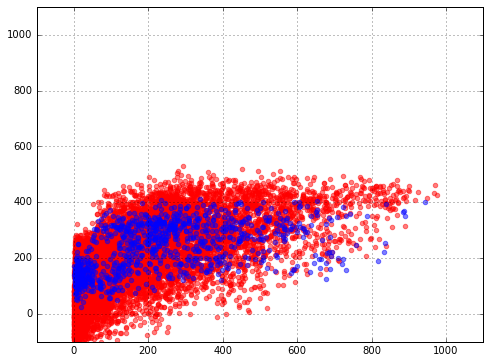

In [69]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

### Другая модель

In [70]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
regressor = RandomForestRegressor(random_state = 0, n_estimators = 50)

In [80]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

In [81]:
%%time
estimator.fit(train_data, train_labels)

CPU times: user 28.5 s, sys: 438 ms, total: 28.9 s
Wall time: 32 s


Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x118b17488>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[('select..._estimators=50, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False))])

In [82]:
#n_estimators = 50
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

46.47475033333334

In [75]:
#max_depth = 20, n_estimators = 50
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

46.731950637128918

In [78]:
len(regressor.feature_importances_)

35

In [ ]:
test_labels[:10]

In [ ]:
estimator.predict(test_data)[:10]

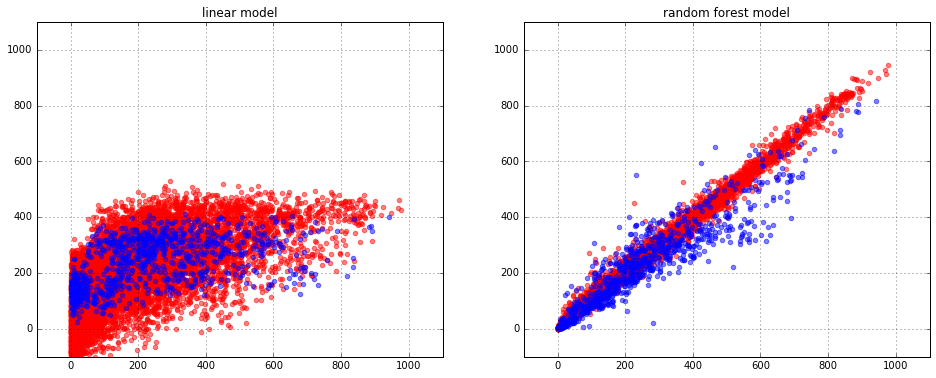

In [77]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')